# **Simulating Everyone's Voice: Exploring ChatGPTs Ability to Simulate Human Annotators (ELMosts)**

# [gpt-3.5-turbo, is the same model used in the ChatGPT product](https://openai.com/blog/introducing-chatgpt-and-whisper-apis)

# **Run chunk below to load presaved data:**

`titles`: original 83k titles (as scraped) \
`classified_titles`: titles with zero-shot classification labels (Controversial, Uncontroversial, Other) and probabilities \
`sampled_controversial_titles`: 50 controversial titles sampled from the original titles

In [1]:
import pandas as pd
# from google.colab import data_table
# data_table.enable_dataframe_formatter()

titles = pd.read_pickle("data/titles.pkl")
classified_titles = pd.read_pickle("data/classified_titles.pkl")
df = pd.DataFrame(classified_titles)

In [2]:
from unidecode import unidecode

# normalized titles
titles = [unidecode(title) for title in titles]


# **Step 1: Data collection and cleaning**

### **1.1 Scraping the St. Cloud Times Newspaper**

In [ ]:
import requests
from selectolax.lexbor import LexborHTMLParser
from concurrent.futures import ThreadPoolExecutor

ThreadPoolExecutor()._max_workers


In [ ]:
%%script echo skipping
# don't run this cell, downlaods titles
# last run 04/06/2023
# ThreadPoolExecutor()._max_workers-4

def get_data(url, selector):
    page = requests.get(url)
    return [node for node in LexborHTMLParser(page.text).css(selector)]


def get_titles(url, selector):
    return [node.text() for node in get_data(url, selector)]


def main():
    site_map = "https://www.sctimes.com/sitemap/"

    months = get_data(site_map, ".sitemap-list-item a")
    days = [
        day
        for month in months
        for day in get_data(
            "https://www.sctimes.com" + month.attributes["href"], ".sitemap-month a"
        )
    ]

    title_selector = ".sitemap-list:not(.sitemap-breadcrumb):not(.sitemap-pagination) .sitemap-list-item"
    with ThreadPoolExecutor(max_workers=16) as executor:
        titles = executor.map(
            lambda day: get_titles(
                "https://www.sctimes.com" + day.attributes["href"], title_selector
            ),
            days,
        )

    return [title for title_list in titles for title in title_list]


titles = main()
# pd.to_pickle(titles, "titles.pkl")

### **1.2 [Zero-shot classification](https://huggingface.co/facebook/bart-large-mnli)**

In [ ]:
from torch.cuda import is_available
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification


In [18]:
%%script echo skipping
# don't run this cell, takes a long time

classifier = pipeline(
    # "zero-shot-classification",
    model="facebook/bart-large-mnli",
    multi_label=False,
    device=0 if is_available() else 1,
    batch_size=32,
)

labels = ["controversial", "uncontroversial", "other"]

classification = classifier(titles, labels)

classified_titles = []

for title, classification in zip(titles, classification):
    classified_titles.append(
        {
            "text": title,
            "controversy_label": classification["labels"][0],
            "controversy_score": classification["scores"][0],
        }
    )

# # pd.to_pickle(classified_titles, "classified_titles.pkl")
# df = pd.DataFrame(classified_titles)


skipping


In [3]:
df.groupby("controversy_label").count()

,text,controversy_score
controversy_label,,
controversial,22766,22766
other,58980,58980
uncontroversial,1748,1748


### **1.4 Sampled controversial titles**

This is a result of the zero-shot classification. We then manually sampled 50 titles from the titles that were classified as controversial.

In [4]:
sampled_controversial_titles = {
# Abortion
    21148: "Abortion takes away the right to life",
    37383: "Trump stands correct; abortion is a crime",
    57736: "Abortion is not health care",
    64999: "Letter: Roe vs. Wade saves women's rights",
    71063: "Letter: Abortion is at heart of America's decay",
    74595: "Anti-abortion laws often rooted in racism",

# Immigration
    2: "Our community can't view newcomers, differences as a threat",
    46009: "It's not acceptable to reject immigrants",
    57287: "'Anchor babies' term highlights racist attitudes",
    19059: "Picture is clear: More guns, more gun deaths",
    32161: "Open carry lacks respect for others",

# Drugs
    30: "MMA votes to support decriminalization of illicit drugs",
    37642: "State should raise tobacco age to 21",
    70896: "Lawmakers pass measure allowing medical marijuana",

# Race
    30080: "There's no denying white privilege",
    54170: "Americans don't want racism to end",

# Free Speech
    60990: "Stand up to Confederate flag assault",
    794: "Book bans are an act of government overreach",
    6649: "Should schools monitor students' online activities?",
    19044: "Twitter should enforce sanctions on Trump's account",
    34745: "Closed meetings on controversial topics build mistrust",

# Politics and Government
    1445: "The U.S. is no longer a functioning democracy: Letter",
    2979: "Is Joe Biden too old to lead the country?",
    15631: "Celebrating Somalia's independence is an insult to America",
    17271: "In politics, women would be just as bad as men",
    45960: "Electoral College needs to go",
    54893: "Republicans put businesses before families",
    58746: "Don't back candidates who won't combat global warming",

# Gender
    16534: "Toxic masculinity turns into an epidemic",
    29465: "Trump's transgender ban brings him dishonor",
    41873: "Sexist perceptions hurt women",
    45532: "mom-sues-teenage-child-transgender-treatment",
    59341: "High court's marriage ruling violates God's law",

# Religion
    2061: "America doesn't need Jesus. It needs separation of church and state",
    9994: "Catholic Church continues to harbor sexual predators",
    14784: "It's our responsibility to fight Islamophobia in St. Cloud",
    37518: "Women as priests? A divisive question of faith",
    39467: "America must refocus on Christianity",
    41706: "Terrorism is to Islam what KKK is to Christianity",
    55819: "Constitution clearly framed by Christian influences",

# BLM
    28: "There is room for the Black National Anthem at NFL games",
    3607: "All lives won't matter until Black lives matter",
    9217: "Minnesota protesters pull down Columbus statue at Capitol",
    40911: "Police walk off WNBA game over BLM jerseys",

# Social Issues
    5214: "Column: Euthanasia is a difficult, necessary decision for pet owners",
    6801: "Radical individualism harms us all, even those who practice it",
    17835: "Silence is assent to evil",
    23422: "Indulgence of social issues has led to extremism",
    45966: "Stop insulting Trump supporters",
    57436: "Heavy topic: Airline to begin weighing passengers",
}


# **Step 2: Annotation**

In [10]:
Human_responsesT = pd.read_excel("data/survey_responses.xlsx", sheet_name="Human Responses").T
ChatGPT_responsesT = pd.read_excel("data/survey_responses.xlsx", sheet_name="ChatGPT Responses").T


In [11]:
def disagreement_labels(df):
    # drop written responses
    # 0-5 are the demographic questions
    df = df.drop(df.index[[0,1,2,3,4,6,14,18,21,28,30,34,49,53,56]])
    df["binary"] = df.iloc[:, 1:].nunique(axis=1).eq(1).astype(int)
    # 1 - r_{maj}(x)
    df['continuous'] = df.iloc[:, 1:11].apply(lambda row: 1 - row.value_counts().max() / len(row), axis=1)
    df['aggregated_label'] = df.iloc[:, 1:11].apply(lambda row: row.mode()[0], axis=1)
    return df


In [12]:
Human_responsesT2 = disagreement_labels(Human_responsesT)
ChatGPT_responsesT2 = disagreement_labels(ChatGPT_responsesT)


In [13]:
Human_responsesT2.iloc[:, 1:11]
ChatGPT_responsesT2.iloc[:, 1:11]
df_concat = pd.concat([Human_responsesT2.iloc[:, 1:11], ChatGPT_responsesT2.iloc[:, 1:11]], axis=1)


In [20]:
group_disagreement = pd.DataFrame(
    {
        "Topic": Human_responsesT2[0],
        "Human": Human_responsesT2["continuous"],
        "ChatGPT": ChatGPT_responsesT2["continuous"],
    }
)


In [22]:
pd.melt(group_disagreement.iloc[:,1:])

,variable,value
0,Human,0.3
1,Human,0.2
2,Human,0.1
3,Human,0.3
4,Human,0.4
...,...,...
95,ChatGPT,0.1
96,ChatGPT,0.1
97,ChatGPT,0.6
98,ChatGPT,0.2


In [23]:
import plotnine as p9

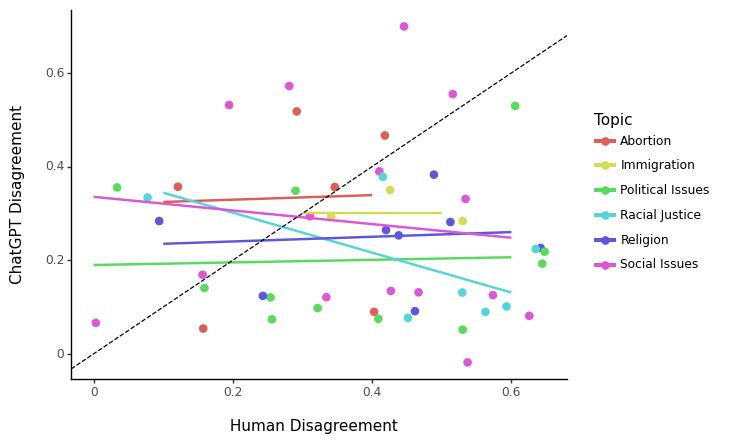

<ggplot: (155007801001)>

In [36]:
(
    p9.ggplot(group_disagreement, p9.aes(x='Human', y='ChatGPT', color='Topic'))
    + p9.geom_point(position=p9.position_jitter(width=0.05, height=0.05),size=2.5)
    + p9.geom_smooth(method='lm', se=False)
    + p9.geom_abline(intercept=0, slope=1, color="black", linetype="dashed", size=0.5)
    + p9.labs(x="\n Human Disagreement", y="ChatGPT Disagreement \n")
    + p9.theme_classic()
)


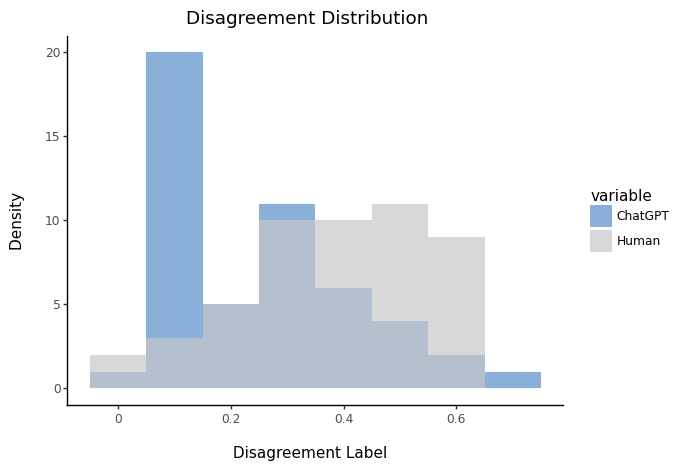

<ggplot: (155007757713)>

In [31]:
(
    p9.ggplot(pd.melt(group_disagreement.iloc[:,1:]), p9.aes(x="value", fill="variable"))
    + p9.geom_histogram(alpha=0.7, position="identity", binwidth=0.1)
    + p9.theme_classic()
    + p9.scale_fill_manual(values=["#588eca", "#c7c8ca"])
    + p9.labs(
        title="Disagreement Distribution", x="\n Disagreement Label", y="Density \n"
    )
)


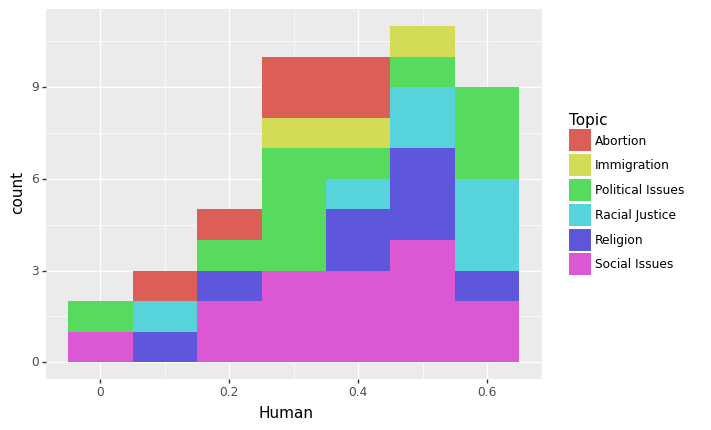

<ggplot: (155007776341)>

In [32]:
(
    p9.ggplot(group_disagreement, p9.aes(x='Human', y=p9.after_stat('count'),fill='Topic'))
    + p9.geom_histogram(binwidth=0.1)
)

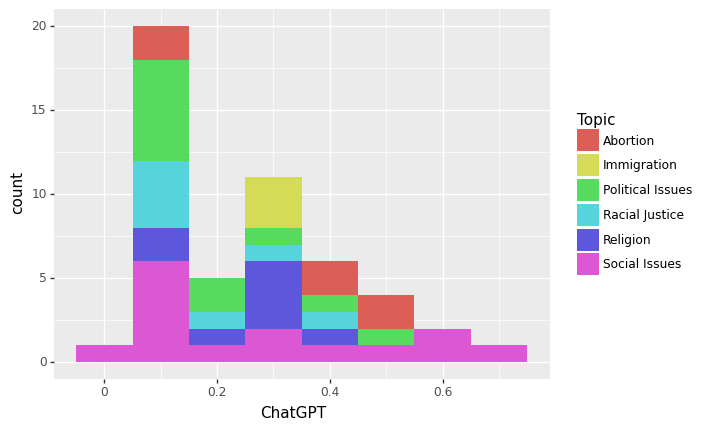

<ggplot: (155007797935)>

In [33]:
(
    p9.ggplot(group_disagreement, p9.aes(x="ChatGPT", y=p9.after_stat('count'),fill='Topic'))
    + p9.geom_histogram(binwidth=0.1)
)

# **Step 3: ChatGPT Annotation**

## **3.1 Prompt**

We are feeding the model two prompts:

> ## System message
> Immerse yourself in the role of the following person: \
> {`person`} \
> Assume the personality, political views, and moral beliefs of the person. You will be given instructions, from this point forward, you are to respond to prompts in this way:
> 
> Person: [The way person would respond]
>
> ## User message
> You will be presented with news article titles related to controversial topics. For each title, you are to select a label from {`labels`} based on your perspective. For only 10 of the titles, signified by (provide a justification), you are to also provide a justification for your choice.
>
> {`articles`}


## **3.2 Create artificial personas**

In [3]:
# prompt templates
from langchain.prompts import (
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
    ChatPromptTemplate,
)

# chat model
from langchain.chat_models import ChatOpenAI

# create streamer
from langchain.callbacks.base import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler


In [4]:
# model parameters
chat_model = ChatOpenAI(
    model_name="gpt-3.5-turbo",
    # temperature=0,
    verbose=True,
    streaming=True,
    callback_manager=CallbackManager([StreamingStdOutCallbackHandler()]),
)


In [5]:
# prompts
prompt = ChatPromptTemplate(
    messages=[
        SystemMessagePromptTemplate.from_template(
            "Immerse yourself in the role of the following person:\n{demographic}\nAssume the personality, political views, and moral beliefs of the person."
        ),
        HumanMessagePromptTemplate.from_template(
            "You will be presented with news article titles related to controversial topics. For all titles, you are to select a label from {labels} based on your perspective. You must select a label for all titles, but provide an explanation only for for the following titles: 1, 8, 11, 13, 19, 20, 23, 37, 40, and 42.\n\n{articles}"
        ),
    ],
    input_variables=["demographic", "labels", "articles"],
)


In [27]:
cont_titles = list(sampled_controversial_titles.values())

In [28]:
for i, title in enumerate(cont_titles):
    cont_titles[i] = f"{i+1}. {title}"

In [29]:
titles_strings = "\n".join(cont_titles)
titles_strings

"1. Abortion takes away the right to life\n2. Trump stands correct; abortion is a crime\n3. Abortion is not health care\n4. Letter: Roe vs. Wade saves women's rights\n5. Letter: Abortion is at heart of America's decay\n6. Anti-abortion laws often rooted in racism\n7. Our community can't view newcomers, differences as a threat\n8. It's not acceptable to reject immigrants\n9. 'Anchor babies' term highlights racist attitudes\n10. Picture is clear: More guns, more gun deaths\n11. Open carry lacks respect for others\n12. MMA votes to support decriminalization of illicit drugs\n13. State should raise tobacco age to 21\n14. Lawmakers pass measure allowing medical marijuana\n15. There's no denying white privilege\n16. Americans don't want racism to end\n17. Stand up to Confederate flag assault\n18. Book bans are an act of government overreach\n19. Should schools monitor students' online activities?\n20. Twitter should enforce sanctions on Trump's account\n21. Closed meetings on controversial t

19. No opinion (I would need more information about the context and purpose of monitoring)

Atheist persona:
37. I have no opinion on whether women should be priests because it's a matter of religious beliefs and traditions.


In [9]:
demographic = """Age Group: 30-29
Sex: Male
Political Ideology: Moderate
Race: Asian
Religious Beliefs: Atheist"""


# inject the titles and demographic into the prompt template
# and generate the output
output = chat_model(
    prompt.format_prompt(
        demographic=demographic,
        labels="Agree, Disagree, No opinion",
        articles=titles_strings,
    ).to_messages()
)


1. Disagree
2. Disagree
3. No opinion
4. Agree
5. Disagree
6. Agree
7. No opinion
8. Agree
9. Agree
10. Agree
11. Agree
12. Agree
13. Agree
14. Agree
15. Agree
16. Disagree
17. Agree
18. Agree
19. No opinion
20. Disagree
21. Agree
22. No opinion
23. No opinion
24. Disagree
25. Disagree
26. Agree
27. No opinion
28. Agree
29. Agree
30. Agree
31. Agree
32. No opinion
33. Disagree
34. Agree
35. Agree
36. Agree
37. No opinion
38. Disagree
39. Disagree
40. Disagree
41. Agree
42. Agree
43. Disagree
44. Disagree
45. No opinion
46. Agree
47. Agree
48. Agree
49. Disagree
50. No opinion

Explanations:
1. I disagree because I believe that women have the right to choose what they want to do with their bodies.
8. I agree that it's not acceptable to reject immigrants because people should be able to live where they want to.
11. I agree that open carry lacks respect for others because carrying weapons in public can make others feel unsafe and uncomfortable.
13. I agree that the state should raise toba

In [10]:
# split the output into individual messages
output.content.split("\n")


['1. Disagree',
 '2. Disagree',
 '3. No opinion',
 '4. Agree',
 '5. Disagree',
 '6. Agree',
 '7. No opinion',
 '8. Agree',
 '9. Agree',
 '10. Agree',
 '11. Agree',
 '12. Agree',
 '13. Agree',
 '14. Agree',
 '15. Agree',
 '16. Disagree',
 '17. Agree',
 '18. Agree',
 '19. No opinion',
 '20. Disagree',
 '21. Agree',
 '22. No opinion',
 '23. No opinion',
 '24. Disagree',
 '25. Disagree',
 '26. Agree',
 '27. No opinion',
 '28. Agree',
 '29. Agree',
 '30. Agree',
 '31. Agree',
 '32. No opinion',
 '33. Disagree',
 '34. Agree',
 '35. Agree',
 '36. Agree',
 '37. No opinion',
 '38. Disagree',
 '39. Disagree',
 '40. Disagree',
 '41. Agree',
 '42. Agree',
 '43. Disagree',
 '44. Disagree',
 '45. No opinion',
 '46. Agree',
 '47. Agree',
 '48. Agree',
 '49. Disagree',
 '50. No opinion',
 '',
 'Explanations:',
 '1. I disagree because I believe that women have the right to choose what they want to do with their bodies.',
 "8. I agree that it's not acceptable to reject immigrants because people should b